# *Voxel microFE pipeline - trabecular bone*
From micro-CT image to voxel-uFE model solution in Calculix

Created on:  23.05.2021 <br />
Last update: 15.01.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), Martino Pani, [Gianluigi Crimi](https://github.com/gcrimi), Enrico Schileo, Fulvia Taddei, Giulia Fraterrigo, 2023
- Data source: the dataset used in this example is part of the public collection of the Living Human Digital Library (LHDL) Project, a project financed by the European Commission (project number: [FP6-IST 026932](https://cordis.europa.eu/project/id/026932)). Human tissues in the LHDL project were collected according to the body donation program of Universitè Libre de Bruxelles (ULB), partner of the project. For info on the dataset see [here](http://projects.kmi.open.ac.uk/lhdl/).
- Code license: MIT
- Narrative license: CC-BY-NC-SA

---
# Aims
![](./../../fem_pipeline.png)
The example implements the following ciclope pipeline:
1. Load and inspect microCT volume data
2. Image pre-processing
    - Apply Gaussian smooth (optional)
    - Resample the dataset (optional)
    - Segment bone tissue
    - Remove unconnected clusters of voxels
3. Mesh generation
    - Generate 3D Unstructured Grid voxel of hexahedra (voxels)
4. Generate voxel-FE model for simulation in CalculX or Abaqus from 3D voxel mesh 
    - Linear, static analysis definition: uniaxial compression test
5. Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
6. Convert Calculix output to .VTK for visualization in Paraview
7. Calculate apparent elastic modulus from reaction forces

---
### Notes on ciclope
* All mesh exports are performed with the [meshio](https://github.com/nschloe/meshio) module.
* **ciclope** handles the definition of material properties and FE analysis parameters (e.g. boundary conditions, simulation steps..) through separate template files. The folders [material_properties](https://github.com/gianthk/ciclope/tree/master/material_properties) and [input_templates](https://github.com/gianthk/ciclope/tree/master/input_templates) contain a library of template files that can be used to generate FE simulations.
  * Additional libraries of [CalculiX](https://github.com/calculix) examples and template files can be found [here](https://github.com/calculix/examples) and [here](https://github.com/calculix/mkraska)
___

### Command line execution of this example
The pipeline described in this notebook can be executed from the command line using the **ciclope** command: <br />

```shell
ciclope test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE.inp -vs 0.0195 0.0195 0.0195 -r 2 -t 63 --smooth 1 --voxelfe --template input_templates/tmp_example01_comp_static_bone.inp
```


Type `python ciclope.py -h` to display the ciclope help with a full list of available command line arguments.

---
# Computational workflow
## Configuration and imports

In [71]:
import sys
sys.path.append('./../../')

In [72]:
import os
import numpy as np
import dxchange
import matplotlib
import matplotlib.pyplot as plt

import mcubes
from scipy import ndimage, misc
from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from ciclope.utils.recon_utils import read_tiff_stack, plot_midplanes
from ciclope.utils.preprocess import remove_unconnected
import ciclope

Uncomment and run the following cell for visualizations using [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [73]:
# import itk
# from itkwidgets import view
# import vtk

[ccx2paraview](https://github.com/calculix/ccx2paraview) is needed for the postprocessing of results

In [74]:
import ccx2paraview

In [75]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

#### Load input data

In [76]:
input_file = './../../test_data/LHDL/3155_D_4_bc/cropped/3155_D_4_bc_0000.tif'

Input data description

|Scan parameters|   |
|:-|:-|
|Lab|LTM@IOR Bologna|
|Sample|Human trabecular bone|
|Voxel size|19.5 micron|
|Preliminary operations|Cropped to 200x200x200 (4mm side)|

Read the input data and define an array of the voxelsize

In [77]:
data_3D = read_tiff_stack(input_file)
vs = np.ones(3)*19.5e-3 # [mm]

In [78]:
type(data_3D)

numpy.ndarray

Inspect the dataset

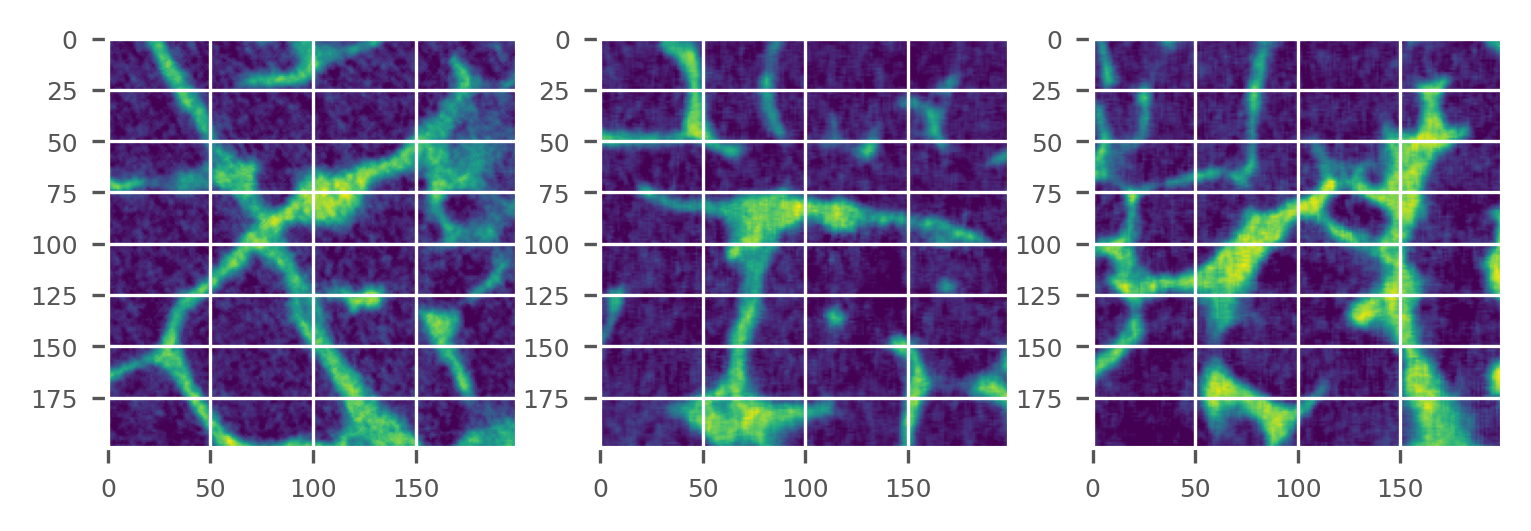

In [79]:
plot_midplanes(data_3D)
plt.show()

Inspect the dataset with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets)

In [80]:
# viewer = view(data_3D, ui_collapsed=True)
# viewer.interpolation = False

Launch itk viewer

In [81]:
# viewer

## Pre-processing
### Gaussian smooth

In [82]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### Resize (downsample) with factor 2

In [83]:
resampling = 2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

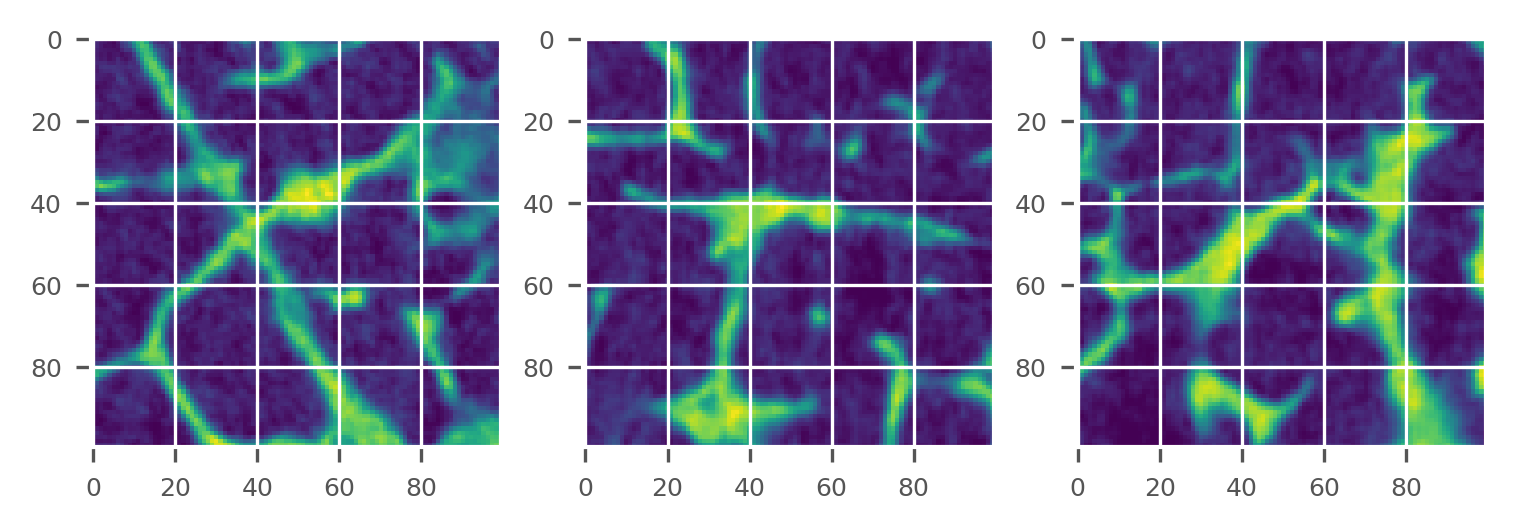

In [84]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

### Thresholding
Use Otsu's method

In [85]:
T = threshold_otsu(data_3D)
print("Threshold: {}".format(T))

Threshold: 80.72472439570987


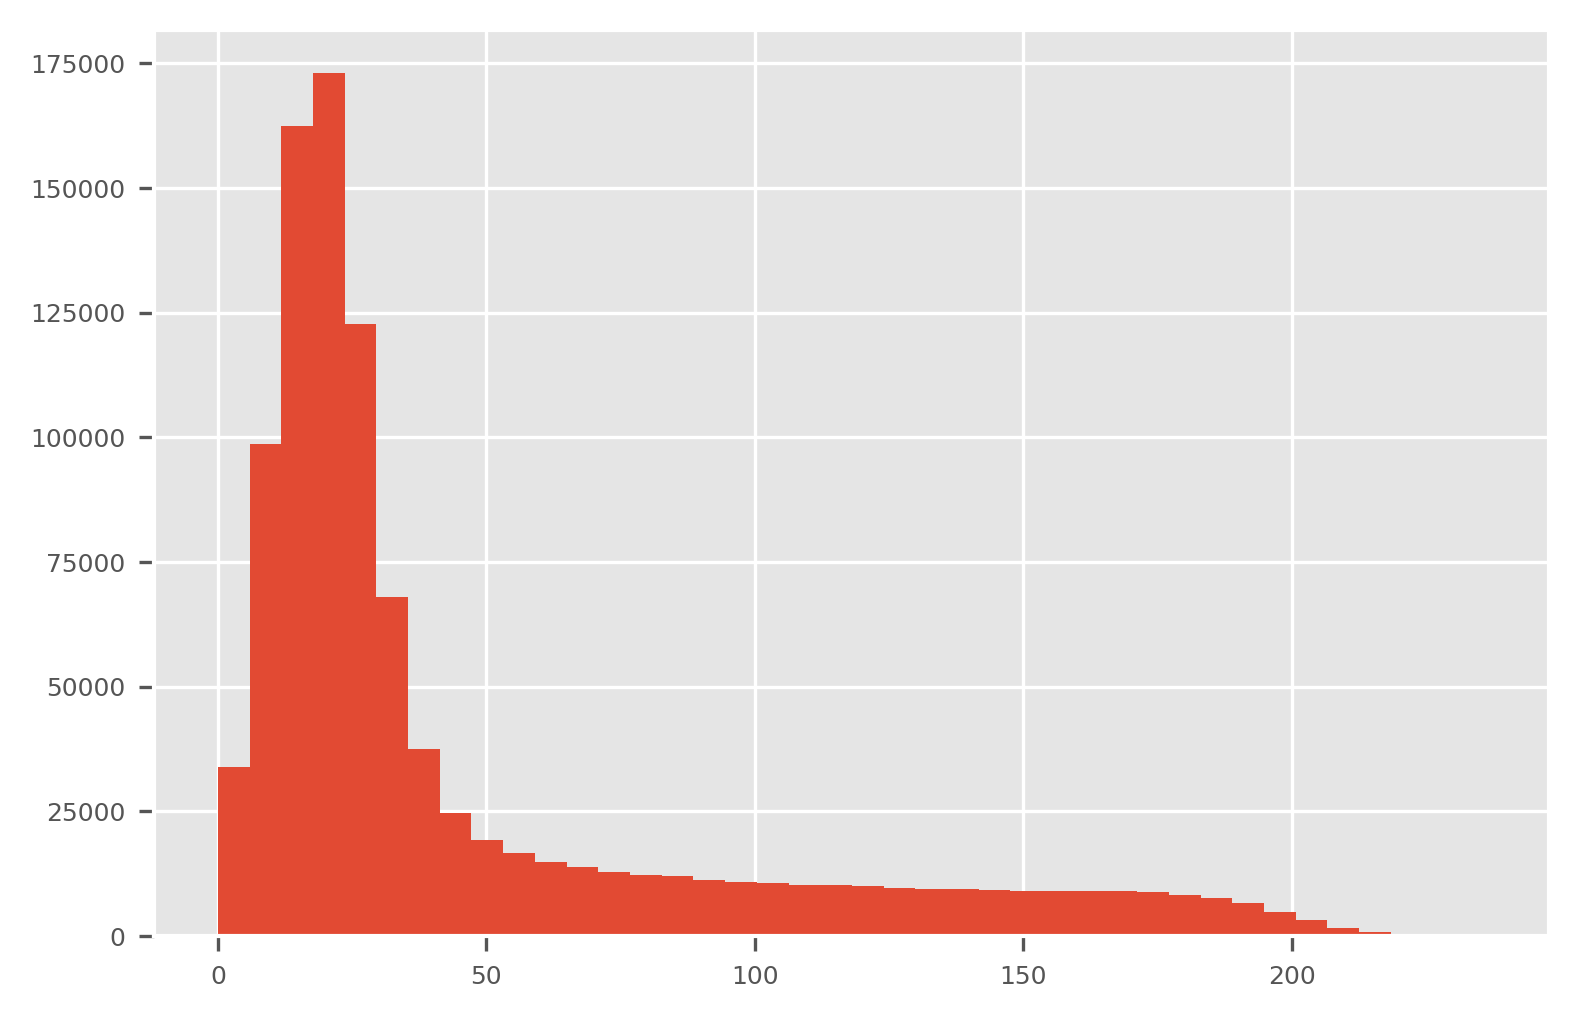

In [86]:
# plot the input image histogram
fig2, ax2 = plt.subplots()
plt.hist(data_3D.ravel(), bins=40)
plt.show()

Apply single global threshold obtained from comparison with histology

In [87]:
# BW = data_3D > T
BW = data_3D > 63 # from comparison with histology

Have a look at the binarized dataset

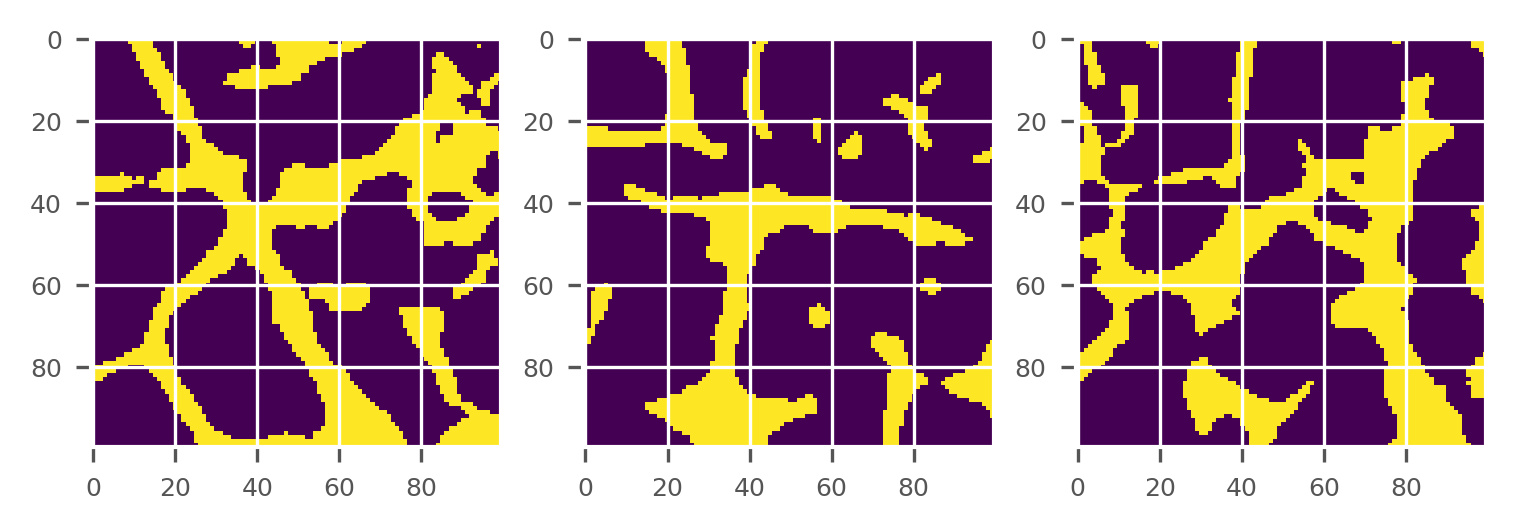

In [88]:
plot_midplanes(BW)
plt.show()

### Morphological close of binary image (optional)

In [89]:
BW = morphology.closing(BW, morphology.ball(3))

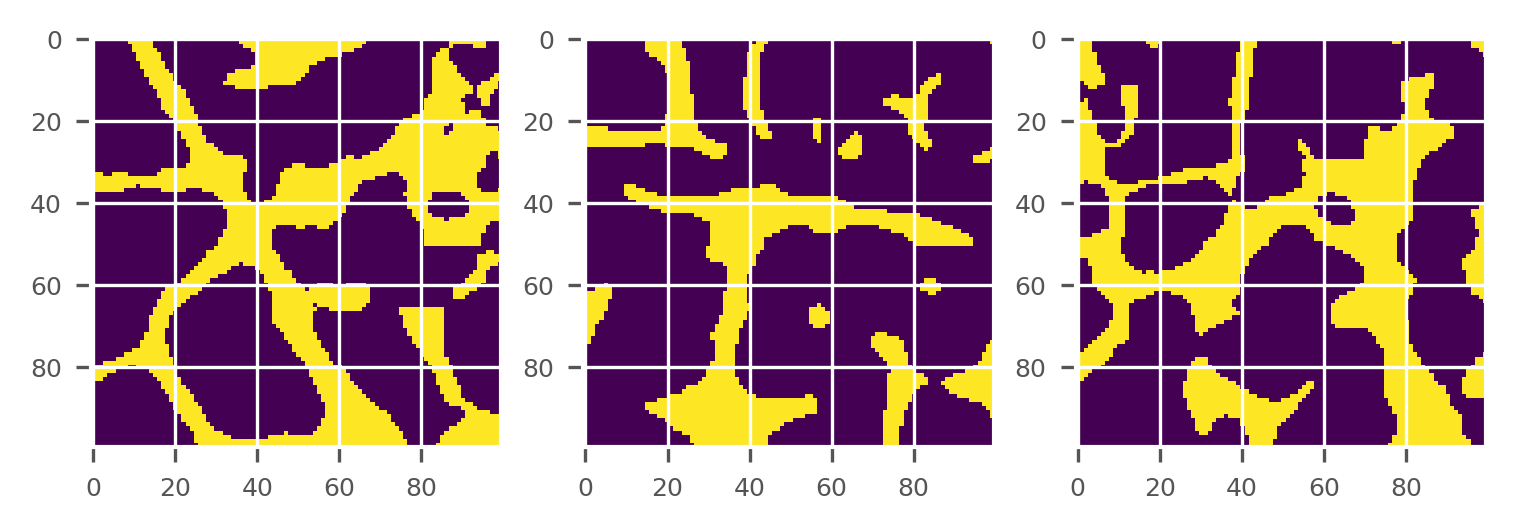

In [90]:
plot_midplanes(BW)
plt.show()

### Detect largest isolated cluster of voxels
The procedure is described by the following 3 steps:
1. Label the BW 3D image

In [91]:
# [labels, n_labels] = measure.label(BW, None, True, 1) # 1 connectivity hop

2. Count the occurrences of each label

In [92]:
# occurrences = np.bincount(labels.reshape(labels.size))

3. Find the largest unconnected label

In [93]:
# largest_label_id = occurrences[1:].argmax()+1
# L = labels == largest_label_id

You can do the same using the function `remove_unconnected` contained in `ciclope.utils.preprocess`

In [94]:
L = remove_unconnected(BW)

Inspect dataset

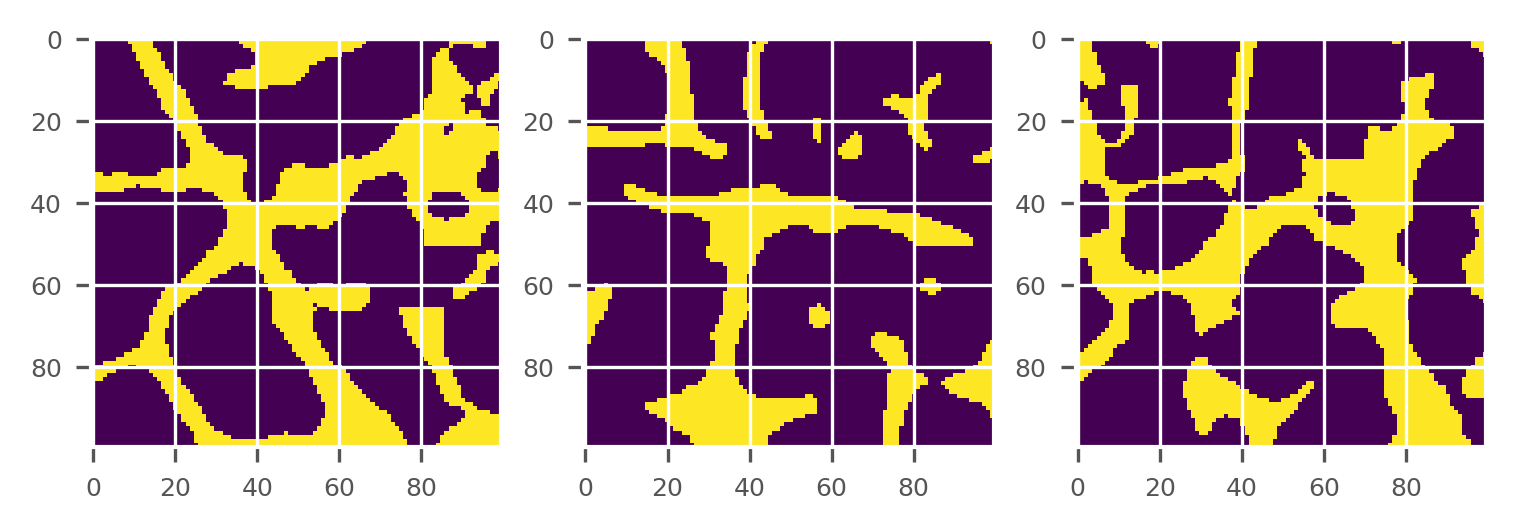

In [95]:
plot_midplanes(L)
plt.show()

## Generate Unstructured Grid Mesh of hexahedra from volume data

In [96]:
mesh = ciclope.core.voxelFE.vol2ugrid(L, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 1030301 nodes and 247062 elements:
INFO:root:<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247062
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0, NODES_X0Y0Z0, NODES_X0Y0Z1
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


#### Write the mesh using `meshio`:
Support for binary data type is not included. We cast GV cell_data to `uint8` 

In [97]:
mesh.cell_data['GV'] = mesh.cell_data['GV'][0].astype('uint8')

In [98]:
print(mesh)

<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247062
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0, NODES_X0Y0Z0, NODES_X0Y0Z1
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


In [99]:
filename_mesh_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelmesh.vtk'

In [100]:
mesh.write(filename_mesh_out)

Visualize the mesh with itkwidgtes

In [101]:
# reader = vtk.vtkUnstructuredGridReader()
# reader.SetFileName(filename_mesh_out)
# reader.Update()
# grid = reader.GetOutput()

In [102]:
# view(geometries=grid)

![LHDL voxel mesh](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_voxelFE.png)

## Write CalculiX input FE files
### Generate voxel-FE model with constant material properties
If a binary ndarray is given as input, the script `vol2voxelfe` will assume that the material property definition is contained in the FE analysis `.INP` template file.

https://classes.engineering.wustl.edu/2009/spring/mase5513/abaqus/docs/v6.6/books/usb/default.htm?startat=pt05ch17s02abm02.html

In [103]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE.inp'

In [104]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone.inp"

In [105]:
!cat {input_template} # on linux
# !type ".\..\..\input_templates\tmp_example01_comp_static_bone.inp # on Win

** ----------------------------------------------------
** Material definition:
*MATERIAL, NAME=BONE
*ELASTIC
18000, 0.3, 0
*SOLID SECTION, ELSET=SET1, MATERIAL=BONE
** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


Generate **CalculiX** input file with the `voxelfe.mesh2voxelfe` method

In [106]:
ciclope.core.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True)

INFO:root:Found cell_data: GV. cell_data range: 1 - 1.
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0', 'NODES_X0Y0Z0', 'NODES_X0Y0Z1']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:Reading Abaqus template file ./../../input_templates/tmp_example01_comp_static_bone.inp
INFO:root:Model with 1030301 nodes and 247062 elements written to file ./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE.inp


## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT` <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [107]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:      1030289
   elements:       247062
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:        11787
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

---
## Post-processing of FE results
### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
- [https://www.paraview.org/](https://www.paraview.org/)
- [https://github.com/calculix/ccx2paraview](https://github.com/calculix/ccx2paraview)

In [108]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading 3155_D_4_bc_voxelFE.frd
INFO:root:336277 nodes
INFO:root:247062 cells
INFO:root:Step 1, time 1.0, U, 3 components, 336277 values
INFO:root:Step 1, time 1.0, S, 6 components, 336277 values
INFO:root:Step 1, time 1.0, E, 6 components, 336277 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 336277 values
INFO:root:1 time increment
INFO:root:Writing 3155_D_4_bc_voxelFE.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 336277 values
INFO:root:Step 1, time 1.0, S, 6 components, 336277 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 336277 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 336277 values
INFO:root:Step 1, time 1.0, E, 6 components, 336277 values
INFO:root:Step 1, time 1.0, E_Mises, 1 components, 336277 values
INFO:root:Step 1, time 1.0, E_Principal, 3 components, 336277 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 336277 values


### Reaction forces

In [109]:
!cat {filename_out_base+'.dat'}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

       -7.960979E-12 -2.579686E-12  2.473045E+02


### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [110]:
A = 200*0.0195*200*0.0195 # [mm2]
epsilon = 0.04/(200*0.0195)

In [111]:
E = (2.47e2/A)/epsilon
print(f"{E:.2f} MPa")

1583.33 MPa


Bone volume fraction

In [112]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f} %")

24.71 %


#### Visualize results in Paraview

In [113]:
!paraview {filename_out_base + '.vtk'}

![U3_displacements](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_voxelFE_U3.png)

Visuailzation with itkwidgtes (does not show field data..)

In [114]:
# reader = vtk.vtkUnstructuredGridReader()
# reader.SetFileName(filename_vtk)
# reader.Update()
# grid = reader.GetOutput()

In [115]:
# view(geometries=grid)

---
## Heterogeneous material properties
The following sections show how to generate a voxel microFE model mapping heterogeneous material properties (tissue elastic modulus) based on the local image grey values.

### Mask the dataset

In [116]:
masked = data_3D.copy().astype('uint8')

In [117]:
masked[~L] = 0

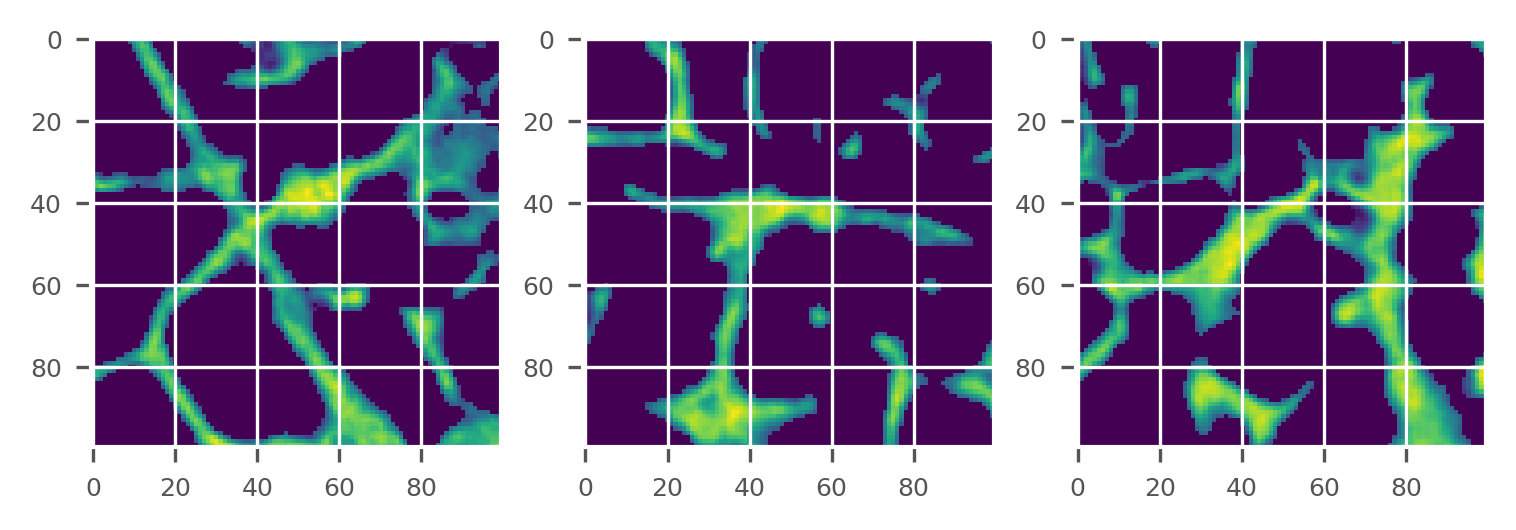

In [118]:
plot_midplanes(masked)

### BMD calibration
Convert Hounsfield Units to Bone Mineral Density

`BMD = HU*(slope_dens/muScaling) + offset_dens`

In [119]:
slope_dens = 3650
muScaling = 720
offset_dens = -20

def HU2BMD(HU, slope_dens, muScaling, offset_dens):
    return HU*(slope_dens/muScaling) + offset_dens

Convert the masked 3D dataset

In [120]:
masked_BMD = HU2BMD(masked, slope_dens, muScaling, offset_dens)

Plot the HU->BMD calibration rule

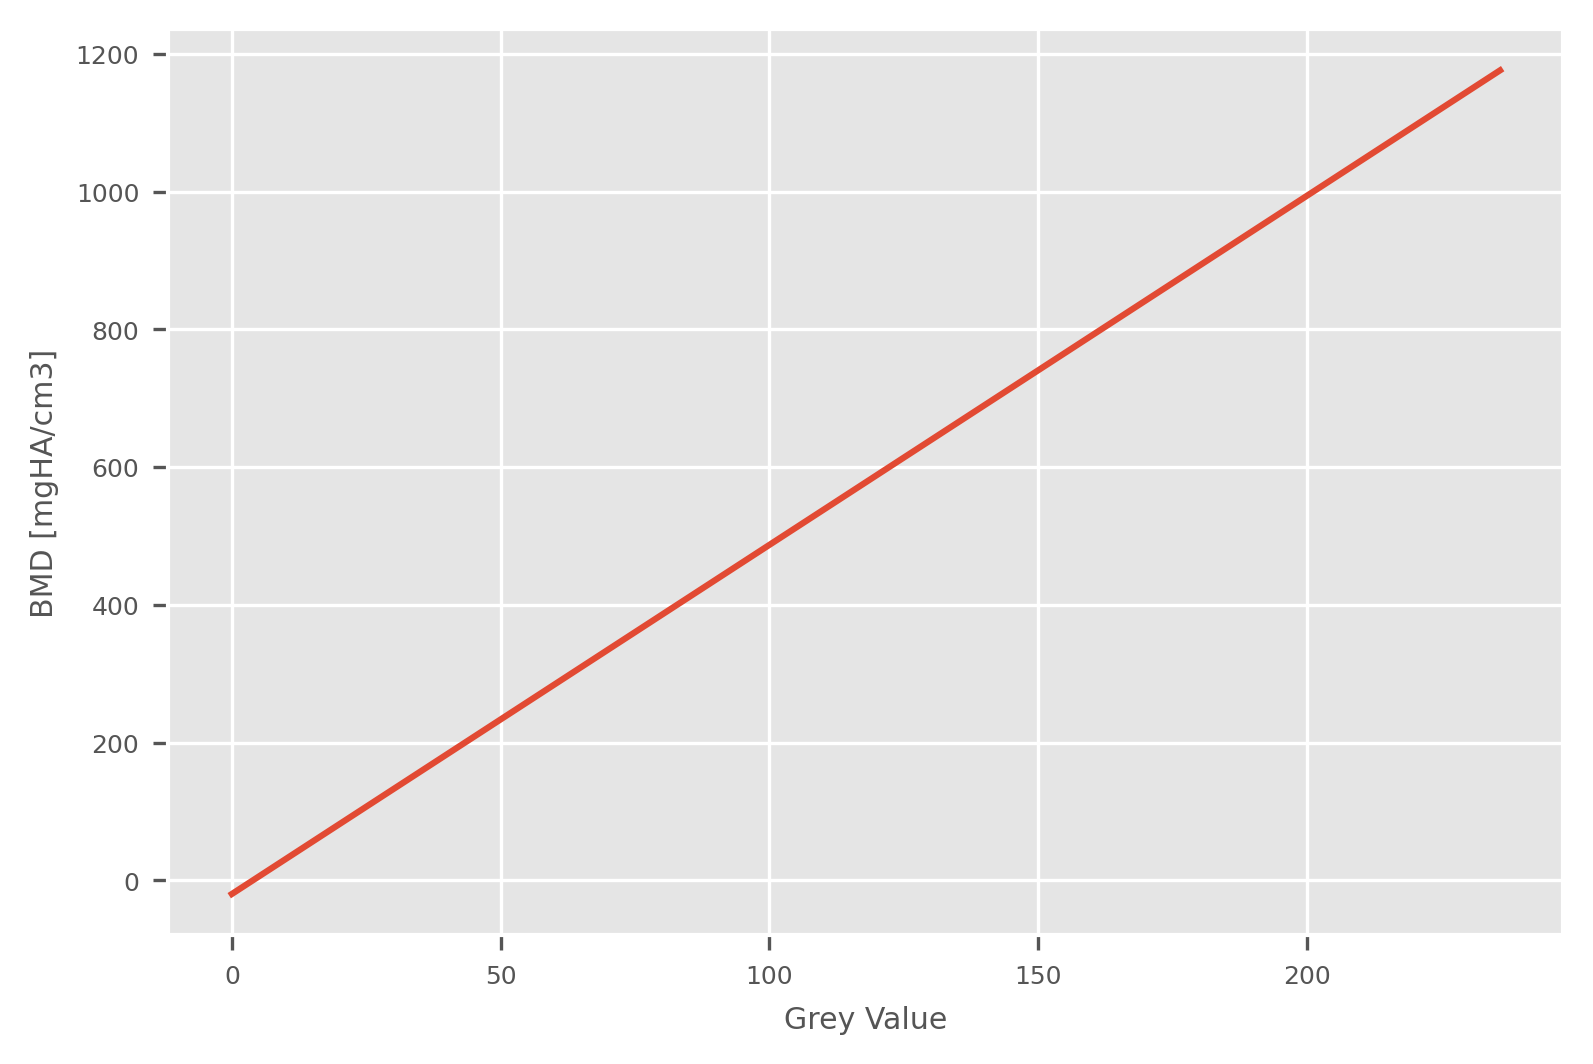

In [121]:
fig, ax = plt.subplots()
plt.plot(np.unique(masked), HU2BMD(np.unique(masked), slope_dens, muScaling, offset_dens))
plt.xlabel('Grey Value')
plt.ylabel('BMD [mgHA/cm3]')
plt.show()
plt.style.use('ggplot')

### Material mapping: BMD-Tissue modulus relationship [[1](#Bourne-2004), [2](#Cox-2022)]
We convert local BMD values to Tissue Elastic Modulus applying the following law:

`E_tissue = BMD * (E_ref/1.1e3) * b`

Where `E_ref` is the compressive tissue modulus for fully mineralized (1100 mgHA/cm3) cortical bone (defined as 20 GPa), and `b` is an exponent defining the nature of the E-BMD relationship (i.e., b = 1 for a linear relationship).

In [122]:
b = 1
E_ref = 20000 # [MPa]
BMD_ref = 1.1e3 # [mgHA/cm3]

def BMD2E(BMD, E_ref=20e3, BMD_ref=1.1e3, b=1):
    return BMD*(E_ref/BMD_ref)*b

Plot the BMD->E calibration rule

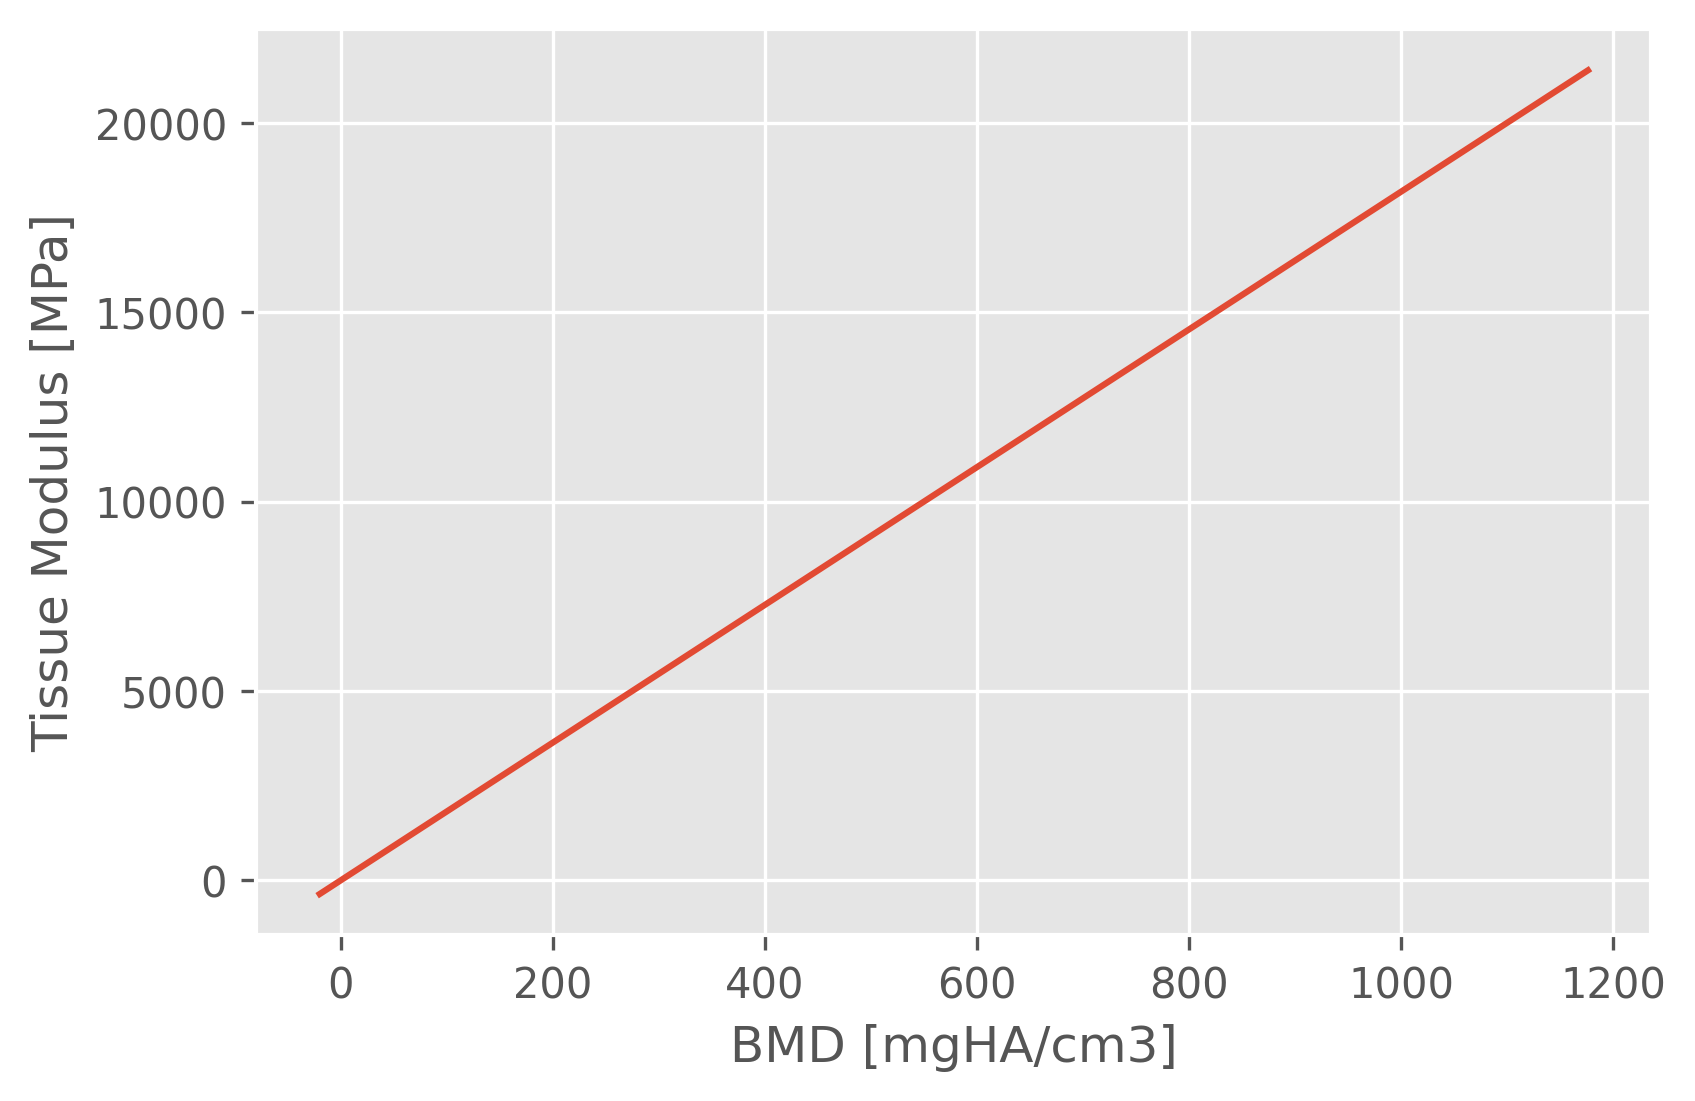

In [123]:
fig, ax = plt.subplots()
plt.plot(np.unique(masked_BMD), BMD2E(np.unique(masked_BMD)))
plt.ylabel('Tissue Modulus [MPa]')
plt.xlabel('BMD [mgHA/cm3]')
plt.show()
plt.style.use('ggplot')

Convert the masked 3D dataset

In [124]:
masked_E = BMD2E(masked_BMD)

Cumulative Density Function of the Tissue Modulus

In [125]:
n_bins = 100
h, bins = np.histogram(masked_E[masked_E>0].ravel(), bins=n_bins)      

Plot the resulting distribution of Tissue Modulus across the sample 

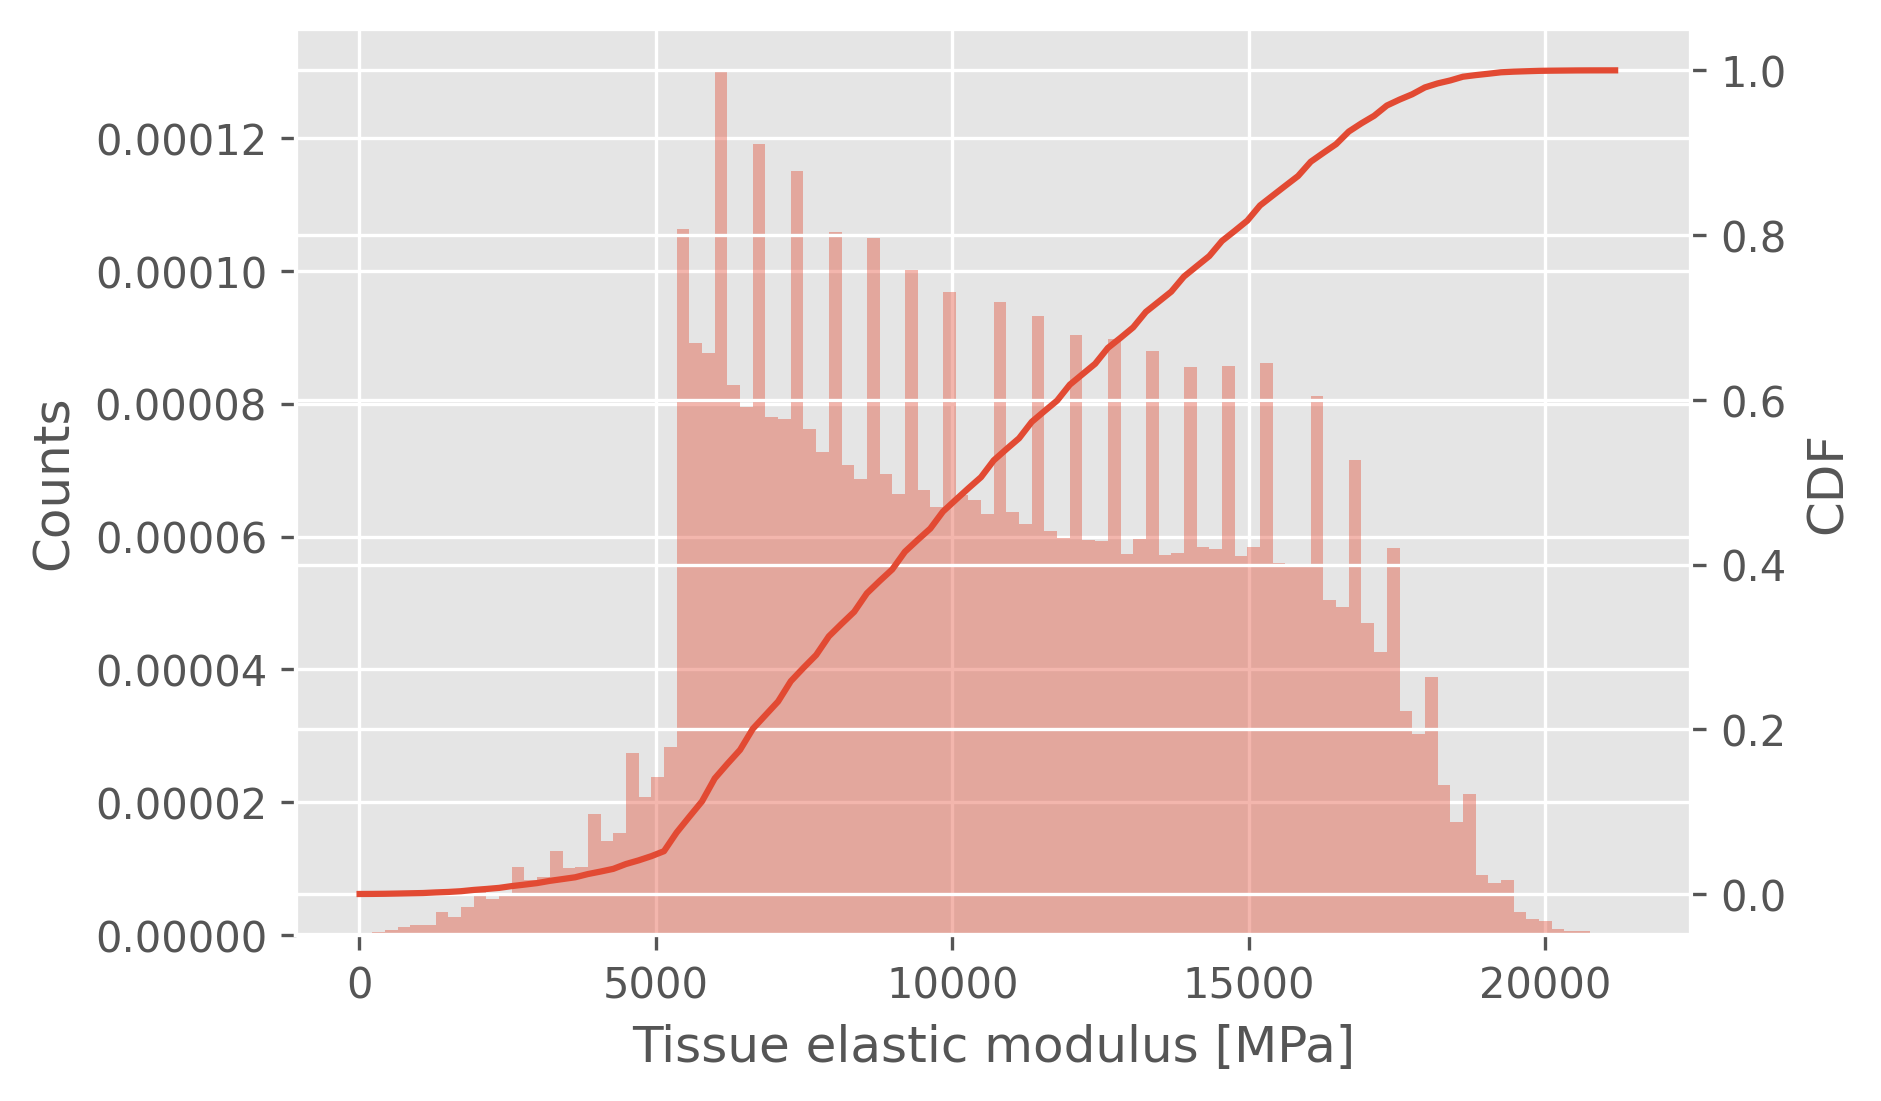

In [126]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.hist(masked_E[masked_E>0].ravel(), bins=n_bins, alpha=0.4, density=True)
ax1.plot(bins[:-1], np.cumsum(h)/np.max(np.cumsum(h)))
ax.set_xlabel('Tissue elastic modulus [MPa]')
ax.set_ylabel('Counts')
ax1.set_ylabel('CDF')
plt.show()

#### Binning the heterogeneous Tissue Modulus image
Digitize the image based on the bins obtained above

In [127]:
masked_E_digitized = np.digitize(masked_E, bins, right=False)

Create list of binned Tissue Modulus values

In [128]:
E_digitized_values = (np.round((bins[1:]+bins[:-1])/2).tolist())
E_digitized_values.insert(0, 0)
E_digitized_values.append(np.round(bins[-1]))

Assign the digitized Tissue Modulus

In [129]:
for digit in np.unique(masked_E_digitized.ravel()):
    masked_E_digitized[masked_E_digitized==digit] = E_digitized_values[digit]

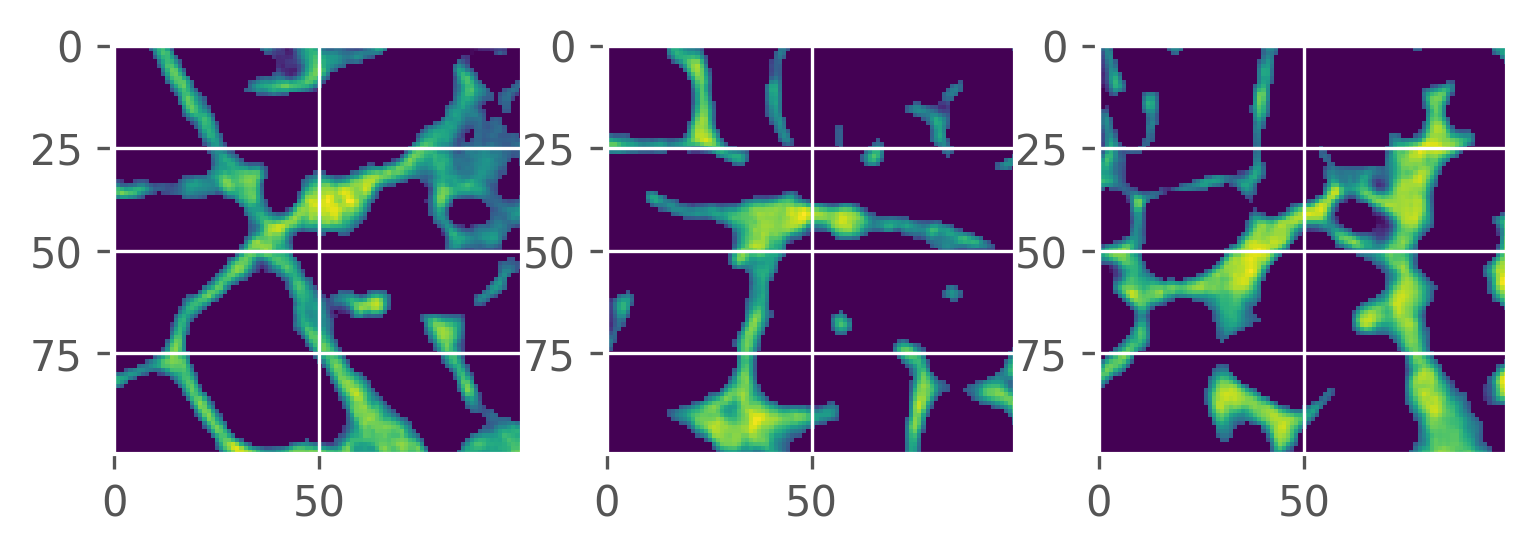

In [130]:
plot_midplanes(masked_E_digitized)

### Generate Unstructured Grid Mesh of hexahedra from volume data

In [131]:
mesh = ciclope.core.voxelFE.vol2ugrid(masked_E_digitized, vs, verbose=True)

INFO:root:Calculating cell array
INFO:root:Detecting node coordinates and boundary nodes
INFO:root:Generated the following mesh with 1030301 nodes and 247058 elements:
INFO:root:<meshio mesh object>
  Number of points: 1030301
  Number of cells:
    hexahedron: 247058
  Point sets: NODES_Y1, NODES_Y0, NODES_X0, NODES_X1, NODES_Z1, NODES_Z0, NODES_X0Y0Z0, NODES_X0Y0Z1
  Cell sets: CELLS_Y1, CELLS_Y0, CELLS_X0, CELLS_X1, CELLS_Z1, CELLS_Z0
  Cell data: GV


In [132]:
print(mesh.cell_data)

{'GV': [array([ 5458,  7382, 11873, ..., 14867, 11445,  6313])]}


Write the mesh for checking using `meshio`

In [133]:
# filename_mesh_out = './../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_voxelmesh.vtk'
# mesh.write(filename_mesh_out)

### Write CalculiX input FE files
#### Generate voxel-FE model with heterogeneous material properties
If the input mesh contains field data `GV`, this can be mapped to heterogeneous material properties.artat=pt05ch17s02abm02.html

In [134]:
filename_out = './../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_matprop_voxelFE.inp'

In [135]:
input_template = "./../../input_templates/tmp_example01_comp_static_bone_matprop.inp"

**Notice that this time we use an input template file which does not contain the material definition section.**

In [136]:
!cat {input_template}

** ---------------------------------------------------
** Analysis definition. The Step module defines the analysis steps and associated output requests.
** More info at:
** https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
** ---------------------------------------------------
*STEP
*STATIC
** All displacements fixed at bottom:
*BOUNDARY
NODES_Z0, 1, 3, 0.0
** Vertical displacement imposed at top:
*BOUNDARY
NODES_Z1, 3, 3, -0.04
** ---------------------------------------------------
** Output request:
*NODE FILE, OUTPUT=2D
U
*NODE PRINT, TOTALS=ONLY, NSET=NODES_Z0
RF
*EL FILE, OUTPUT=2D
S, E
*END STEP


Generate **CalculiX** input file with the `voxelfe.mesh2voxelfe` method. This time we activate the option `matprop`

In [137]:
help(ciclope.core.voxelFE.mesh2voxelfe)

Help on function mesh2voxelfe in module ciclope.core.voxelFE:

mesh2voxelfe(mesh, templatefile, fileout, matprop=None, keywords=['NSET', 'ELSET'], eltype='C3D8', matpropbits=8, refnode=None, verbose=False)
    Generate ABAQUS voxel Finite Element (FE) input file from 3D Unstructured Grid mesh data.
    The file written is an input file (.INP) in ABAQUS syntax that can be solved using ABAQUS or CALCULIX.
    The user can define a material mapping strategy for the conversion of local GVs to local material properties in the FE model.
    Material mapping laws are defined in separate template file(s) (see "prop.inp" and "property_temp_bone.inp" for examples).
    Boundary conditions, analysis type and output requests are defined in a separate template file (see "tmp.inp" for an example).
    Info on analysis definition at: https://abaqus-docs.mit.edu/2017/English/SIMACAECAERefMap/simacae-m-Sim-sb.htm#simacae-m-Sim-sb
    
    Parameters
    ----------
    mesh : meshio
        Unstructured

In [139]:
ciclope.core.voxelFE.mesh2voxelfe(mesh, input_template, filename_out, verbose=True,
                             keywords=['NSET', 'ELSET', 'PROPERTY'],
                             matprop = {
                                 "file": ["./../../material_properties/bone_Etissue.inp"],
                                 "range": [[1, 22000]]
                                       },
                             matpropbits=16)

INFO:root:Found cell_data: GV. cell_data range: 112 - 21389.
INFO:root:Checking GV range for user material properties
INFO:root:Start writing INP file
INFO:root:Writing model nodes to INP file
INFO:root:Writing model elements to INP file
INFO:root:Additional nodes sets generated: ['NODES_Y1', 'NODES_Y0', 'NODES_X0', 'NODES_X1', 'NODES_Z1', 'NODES_Z0', 'NODES_X0Y0Z0', 'NODES_X0Y0Z1']
INFO:root:Additional cell sets generated: ['CELLS_Y1', 'CELLS_Y0', 'CELLS_X0', 'CELLS_X1', 'CELLS_Z1', 'CELLS_Z0']
INFO:root:User material properties defined. Writing material property section of INP file
INFO:root:Reading Abaqus template file ./../../input_templates/tmp_example01_comp_static_bone_matprop.inp
INFO:root:Model with 1030301 nodes and 247058 elements written to file ./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_matprop_voxelFE.inp


Run in CalculiX

In [140]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/LHDL/3155_D_4_bc/results/3155_D_4_bc_matprop_voxelFE"


************************************************************

CalculiX Version 2.17, Copyright(C) 1998-2020 Guido Dhondt
CalculiX comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under
certain conditions, see gpl.htm

************************************************************

You are using an executable made on Sun 10 Jan 2021 11:34:19 AM CET

  The numbers below are estimated upper bounds

  number of:

   nodes:      1030289
   elements:       247058
   one-dimensional elements:            0
   two-dimensional elements:            0
   integration points per element:            8
   degrees of freedom per node:            3
   layers per element:            1

   distributed facial loads:            0
   distributed volumetric loads:            0
   concentrated loads:            0
   single point constraints:        11787
   multiple point constraints:            1
   terms in all multiple point constraints:            1
   tie con

### Post-processing of FE results
#### Convert Calculix output to Paraview

In [141]:
filename_out_base, ext_out = os.path.splitext(filename_out)
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

INFO:root:Reading 3155_D_4_bc_matprop_voxelFE.frd
INFO:root:336275 nodes
INFO:root:247058 cells
INFO:root:Step 1, time 1.0, U, 3 components, 336275 values
INFO:root:Step 1, time 1.0, S, 6 components, 336275 values
INFO:root:Step 1, time 1.0, E, 6 components, 336275 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 336275 values
INFO:root:1 time increment
INFO:root:Writing 3155_D_4_bc_matprop_voxelFE.vtk


INFO:root:Step 1, time 1.0, U, 3 components, 336275 values
INFO:root:Step 1, time 1.0, S, 6 components, 336275 values
INFO:root:Step 1, time 1.0, S_Mises, 1 components, 336275 values
INFO:root:Step 1, time 1.0, S_Principal, 3 components, 336275 values
INFO:root:Step 1, time 1.0, E, 6 components, 336275 values
INFO:root:Step 1, time 1.0, E_Mises, 1 components, 336275 values
INFO:root:Step 1, time 1.0, E_Principal, 3 components, 336275 values
INFO:root:Step 1, time 1.0, ERROR, 1 components, 336275 values


#### Reaction forces

In [142]:
!cat {filename_out_base+'.dat'}


 total force (fx,fy,fz) for set NODES_Z0 and time  0.1000000E+01

        1.131664E-13 -2.036052E-12  1.370934E+02


#### Apparent elastic modulus
`E_app = (F_tot / A) / epsilon`

In [143]:
A = 200*0.0195*200*0.0195 # [mm2]
epsilon = 0.04/(200*0.0195)

In [144]:
E = (1.37e2/A)/epsilon
print(f"{E:.2f} MPa")

878.21 MPa


Bone volume fraction

In [145]:
BVTV = 100*np.sum(L)/L.size
print(f"{BVTV:.2f} %")

24.71 %


#### Visualize results in Paraview

In [146]:
!paraview {filename_out_base + '.vtk'}

![Smises_matprop](./../../test_data/LHDL/3155_D_4_bc/results/LHDL_voxelFE_matprop_Smises.png)

---
# Dependencies

In [147]:
import watermark

In [148]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2023-01-15T20:34:35.935795+03:00

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 8.4.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.0-23-amd64
Machine     : x86_64
Processor   : 
CPU cores   : 8
Architecture: 64bit

skimage     : 0.18.1
sys         : 3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) 
[GCC 7.5.0]
dxchange    : 0.1.6
ciclope     : 1.1.9
matplotlib  : 3.5.2
watermark   : 2.3.1
scipy       : 1.8.1
numpy       : 1.22.4
ccx2paraview: 3.0.0



---
# References
<a name="Bourne-2004"></a>
1. Bourne, Benjamin C., and Marjolein C. H. van der Meulen. 2004. “Finite Element Models Predict Cancellous Apparent Modulus When Tissue Modulus Is Scaled from Specimen CT-Attenuation.” Journal of Biomechanics 37 (5): 613–21. https://doi.org/10.1016/j.jbiomech.2003.10.002.
<a name="Cox-2022"></a>
2. Cox, Jason M., Joshua D. Smith, Marjolein C. H. van der Meulen, and Jacqueline H. Cole. 2022. “Heterogeneous Tissue Modulus Improved Prediction of Mechanical Behavior in Osteoporotic Vertebral Cancellous Bone.” bioRxiv. https://doi.org/10.1101/2021.11.30.470675.

---
# Acknowledgements
- This notebook was developed within [Building the Jupyter Community in MSK Imaging Research](https://github.com/JCMSK/2022_JCW), a Jupyter Community Workshop sponsored by [NUMFocus](https://numfocus.org/)